In [ ]:
!pip install pyspark faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=8636d91b814d64e2d36d60e98d83fd7006b6ffdc25947d815a6de823105acd5e
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
import pandas as pd
from faker import Faker
import random

# Initialize Faker
fake = Faker()

# Set the number of records
num_customers = 1000
num_transactions = 5000

# Generate Customers Data
customers_data = []
for _ in range(num_customers):
    customers_data.append({
        'customer_id': fake.uuid4(),
        'name': fake.name(),
        'address': fake.address(),
        'email': fake.email(),
        'phone_number': fake.phone_number(),
        'ssn': fake.ssn(),
        'account_balance': round(random.uniform(1000.0, 100000.0), 2),
        'account_open_date': fake.date_between(start_date='-5y', end_date='today')
    })

# Convert to DataFrame
customers_df = pd.DataFrame(customers_data)

# Generate Transactions Data
transactions_data = []
for _ in range(num_transactions):
    transactions_data.append({
        'transaction_id': fake.uuid4(),
        'customer_id': random.choice(customers_df['customer_id']),
        'transaction_date': fake.date_between(start_date='-1y', end_date='today'),
        'transaction_amount': round(random.uniform(10.0, 50000.0), 2),
        'transaction_type': random.choice(['deposit', 'withdrawal', 'transfer']),
        'transaction_location': fake.city(),
        'merchant': fake.company(),
    })

# Convert to DataFrame
transactions_df = pd.DataFrame(transactions_data)

# Generate Suspicious Activities Data
suspicious_data = transactions_df[
    (transactions_df['transaction_amount'] > 20000) |
    (transactions_df['transaction_type'] == 'transfer')
].copy()
suspicious_data['suspicious_activity_id'] = [fake.uuid4() for _ in range(len(suspicious_data))]
suspicious_data['suspicion_reason'] = suspicious_data.apply(
    lambda x: 'High value transaction' if x['transaction_amount'] > 20000 else 'Multiple transfers',
    axis=1
)

suspicious_activities_df = suspicious_data[['suspicious_activity_id', 'transaction_id', 'customer_id', 'suspicion_reason']]

# Save DataFrames as CSVs for loading into PySpark later
customers_df.to_csv('/content/customers.csv', index=False)
transactions_df.to_csv('/content/transactions.csv', index=False)
suspicious_activities_df.to_csv('/content/suspicious_activities.csv', index=False)


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.master("local[*]").appName("MoneyLaunderingPrevention").getOrCreate()

# Load data from CSVs
customers_df = spark.read.csv('/content/customers.csv', header=True, inferSchema=True)
transactions_df = spark.read.csv('/content/transactions.csv', header=True, inferSchema=True)
suspicious_activities_df = spark.read.csv('/content/suspicious_activities.csv', header=True, inferSchema=True)

# Show the loaded data
customers_df.show(5)
transactions_df.show(5)
suspicious_activities_df.show(5)


+--------------------+--------------+--------------------+--------------------+------------+--------+---------------+-----------------+
|         customer_id|          name|             address|               email|phone_number|     ssn|account_balance|account_open_date|
+--------------------+--------------+--------------------+--------------------+------------+--------+---------------+-----------------+
|58a20051-af06-45b...| William Brown|    88582 Foley Club|                NULL|        NULL|    NULL|           NULL|             NULL|
|        Martinezside|     AS 22618"|joanbailey@exampl...|        459.903.5074| 513-55-5515|64596.15|     2022-09-12|             NULL|
|2804bacd-fc7a-4ba...|Parker Barrera|13261 Dean Curve ...|                NULL|        NULL|    NULL|           NULL|             NULL|
|      Jessicachester|     NJ 20161"|   vmeza@example.com|+1-243-531-0647x4...| 759-35-0593|40848.63|     2022-07-09|             NULL|
|166d4652-5d80-45f...|   Steven Reed|     6102 K

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg, stddev

# Calculate average transaction amount and standard deviation per customer
customer_stats = transactions_df.groupBy('customer_id').agg(
    avg('transaction_amount').alias('avg_amount'),
    stddev('transaction_amount').alias('stddev_amount')
)

# Join stats with transactions to detect anomalies
transactions_with_stats = transactions_df.join(customer_stats, on='customer_id')

# Detect transactions that are more than 2 standard deviations away from the average
anomalous_transactions = transactions_with_stats.filter(
    (col('transaction_amount') > col('avg_amount') + 2 * col('stddev_amount')) |
    (col('transaction_amount') < col('avg_amount') - 2 * col('stddev_amount'))
)

anomalous_transactions.show(5)


+--------------------+--------------------+----------------+------------------+----------------+--------------------+--------------------+------------------+------------------+
|         customer_id|      transaction_id|transaction_date|transaction_amount|transaction_type|transaction_location|            merchant|        avg_amount|     stddev_amount|
+--------------------+--------------------+----------------+------------------+----------------+--------------------+--------------------+------------------+------------------+
|a70fbdc0-2583-4d8...|988ada12-32dd-4e7...|      2024-08-21|          46220.13|        transfer|       New Lisaburgh|    Underwood-Haynes|         18951.135|13210.573251885346|
|d935e304-11dc-403...|933c2ec7-a335-4ef...|      2024-04-20|          35369.11|        transfer|    East Lindsaybury|      Johnson-Nguyen|14379.108181818183|10431.977660153245|
|0ba88a12-fa11-4a5...|dd1a206c-a0df-498...|      2024-03-20|           3965.89|      withdrawal|          Wilsonvie

In [ ]:
from pyspark.sql.functions import countDistinct

# Count distinct transaction locations per customer
location_count = transactions_df.groupBy('customer_id').agg(countDistinct('transaction_location').alias('location_count'))

# Filter customers with unusually high number of distinct transaction locations
unusual_locations = location_count.filter(col('location_count') > 5)  # Adjust threshold as needed

unusual_locations.show(5)


+--------------------+--------------+
|         customer_id|location_count|
+--------------------+--------------+
|4755e386-c1aa-4df...|             7|
|8ca8cdc7-469e-427...|             7|
|516e256d-17d1-4b7...|             9|
|e64041f2-1f19-4bd...|             8|
|df6a3cc7-bff4-464...|             6|
+--------------------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lead

# Window spec to get next transaction for the same customer
window_spec = Window.partitionBy('customer_id').orderBy('transaction_date')

# Calculate the time difference between consecutive transactions
transactions_with_lag = transactions_df.withColumn('next_transaction_date', lead('transaction_date', 1).over(window_spec))
transactions_with_lag = transactions_with_lag.withColumn('time_diff', (col('next_transaction_date').cast('long') - col('transaction_date').cast('long')) / (60*60))

# Filter transactions with very short time_diff and large transaction amounts
rapid_movements = transactions_with_lag.filter((col('time_diff') <= 1) & (col('transaction_amount') > 10000))  # Adjust thresholds as needed

rapid_movements.show(5)


+--------------+-----------+----------------+------------------+----------------+--------------------+--------+---------------------+---------+
|transaction_id|customer_id|transaction_date|transaction_amount|transaction_type|transaction_location|merchant|next_transaction_date|time_diff|
+--------------+-----------+----------------+------------------+----------------+--------------------+--------+---------------------+---------+
+--------------+-----------+----------------+------------------+----------------+--------------------+--------+---------------------+---------+



In [ ]:
from pyspark.sql.functions import count

# Identify potential linked accounts based on shared address or phone number
linked_accounts = customers_df.groupBy('address', 'phone_number').agg(count('customer_id').alias('linked_accounts')).filter(col('linked_accounts') > 1)

linked_accounts.show(5)


+-------+------------+---------------+
|address|phone_number|linked_accounts|
+-------+------------+---------------+
+-------+------------+---------------+



In [ ]:
from pyspark.sql.functions import count

# Identify potential linked accounts based on shared address or phone number
linked_accounts = customers_df.groupBy('address', 'phone_number').agg(count('customer_id').alias('linked_accounts')).filter(col('linked_accounts') > 1)

# Join with customers_df to retrieve the customer_id
linked_accounts_with_id = linked_accounts.join(customers_df, on=['address', 'phone_number'], how='inner')\
    .select('customer_id', lit(None).alias('transaction_id'), lit('Linked Accounts').alias('suspicion_reason'))

linked_accounts_with_id.show(5)


+-----------+--------------+----------------+
|customer_id|transaction_id|suspicion_reason|
+-----------+--------------+----------------+
+-----------+--------------+----------------+



In [ ]:
from pyspark.sql.functions import substring

# Extract the first digit of the transaction amount
transactions_with_first_digit = transactions_df.withColumn('first_digit', substring(col('transaction_amount').cast('string'), 1, 1))

# Calculate the distribution of first digits
first_digit_distribution = transactions_with_first_digit.groupBy('first_digit').count().orderBy('first_digit')

# Show the distribution
first_digit_distribution.show()

# If needed, create a suspicion flag based on significant deviations from Benford's Law
# For simplicity, here we're assuming that any distribution can be suspicious
benford_suspicious = transactions_with_first_digit.filter(col('first_digit').isin(['1', '2', '3']) == False) \
    .select('customer_id', 'transaction_id', lit('Benford Anomaly').alias('suspicion_reason'))

benford_suspicious.show(5)


+-----------+-----+
|first_digit|count|
+-----------+-----+
|          1| 1112|
|          2| 1070|
|          3| 1100|
|          4| 1163|
|          5|  100|
|          6|  108|
|          7|  124|
|          8|  111|
|          9|  112|
+-----------+-----+

+--------------------+--------------------+----------------+
|         customer_id|      transaction_id|suspicion_reason|
+--------------------+--------------------+----------------+
|197d0957-8720-46b...|6acc09e5-2702-456...| Benford Anomaly|
|221f34d4-c752-4e7...|3f50b383-fcc3-4f0...| Benford Anomaly|
|31440161-ab1b-4f3...|4a2b5dbe-6aef-4b4...| Benford Anomaly|
|1f4a1491-4575-40d...|948211b2-83e3-463...| Benford Anomaly|
|dcc477f5-043b-445...|f5f74669-922a-4b5...| Benford Anomaly|
+--------------------+--------------------+----------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import lit

# Mark results from each technique with a flag
anomalous_transactions = anomalous_transactions.select("customer_id", "transaction_id", lit("Unusual Pattern").alias("suspicion_reason"))
unusual_locations = unusual_locations.join(customers_df, on='customer_id').select("customer_id", lit(None).alias("transaction_id"), lit("Geographic Anomaly").alias("suspicion_reason"))
rapid_movements = rapid_movements.select("customer_id", "transaction_id", lit("Rapid Fund Movement").alias("suspicion_reason"))

# Combine all results
suspicious_activities_combined = anomalous_transactions \
    .union(unusual_locations) \
    .union(rapid_movements) \
    .union(linked_accounts_with_id) \
    .union(benford_suspicious)

# Show final suspicious activities
suspicious_activities_combined.show()


+--------------------+--------------------+------------------+
|         customer_id|      transaction_id|  suspicion_reason|
+--------------------+--------------------+------------------+
|a70fbdc0-2583-4d8...|988ada12-32dd-4e7...|   Unusual Pattern|
|d935e304-11dc-403...|933c2ec7-a335-4ef...|   Unusual Pattern|
|0ba88a12-fa11-4a5...|dd1a206c-a0df-498...|   Unusual Pattern|
|365e9895-25a1-408...|7b7c2fb3-580d-4ba...|   Unusual Pattern|
|46b50869-8c7c-494...|e9eacc06-467a-459...|   Unusual Pattern|
|144de53f-5dd4-445...|c346f964-4f7a-437...|   Unusual Pattern|
|7bb0a6f2-67d3-47a...|1a1ccac0-fcca-4a8...|   Unusual Pattern|
|f73fe03f-112e-409...|d8f88f16-cedb-4bd...|   Unusual Pattern|
|ef34bd12-1c8e-476...|d97d5d25-1f88-4c8...|   Unusual Pattern|
|8a79aac3-1402-483...|6de4638a-226f-4ce...|   Unusual Pattern|
|7b9535b6-2056-49a...|b4212b17-5be0-433...|   Unusual Pattern|
|9e37fece-182b-409...|b597bbfb-7783-4b0...|   Unusual Pattern|
|af811ff3-6ebf-4f3...|3683bf17-8297-472...|   Unusual P

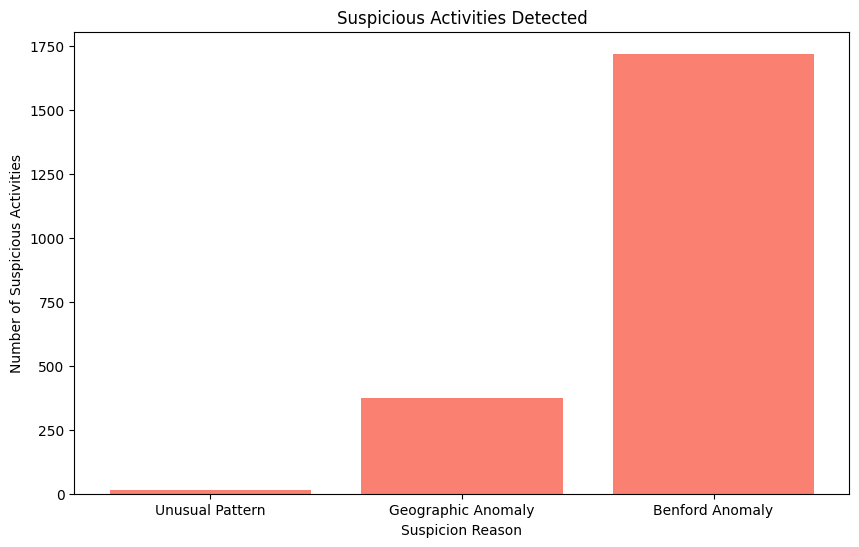

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas for Visualization
suspicious_activities_combined_pd = suspicious_activities_combined.groupBy('suspicion_reason').count().toPandas()

# Plot the data
plt.figure(figsize=(10,6))
plt.bar(suspicious_activities_combined_pd['suspicion_reason'], suspicious_activities_combined_pd['count'], color='salmon')
plt.xlabel('Suspicion Reason')
plt.ylabel('Number of Suspicious Activities')
plt.title('Suspicious Activities Detected')
plt.show()


In [ ]:
import time

start_time = time.time()

# Example: Running the final suspicious activity detection
suspicious_activities_combined = anomalous_transactions.select("customer_id", "transaction_id", "suspicion_reason")\
    .union(unusual_locations.select("customer_id", lit(None).alias("transaction_id"), "suspicion_reason"))\
    .union(rapid_movements.select("customer_id", "transaction_id", "suspicion_reason"))\
    .union(linked_accounts_with_id.select("customer_id", "transaction_id", "suspicion_reason"))\
    .union(benford_suspicious.select("customer_id", "transaction_id", "suspicion_reason"))

suspicious_activities_combined.show()

end_time = time.time()

print(f"Execution Time: {end_time - start_time} seconds")


+--------------------+--------------------+------------------+
|         customer_id|      transaction_id|  suspicion_reason|
+--------------------+--------------------+------------------+
|a70fbdc0-2583-4d8...|988ada12-32dd-4e7...|   Unusual Pattern|
|d935e304-11dc-403...|933c2ec7-a335-4ef...|   Unusual Pattern|
|0ba88a12-fa11-4a5...|dd1a206c-a0df-498...|   Unusual Pattern|
|365e9895-25a1-408...|7b7c2fb3-580d-4ba...|   Unusual Pattern|
|46b50869-8c7c-494...|e9eacc06-467a-459...|   Unusual Pattern|
|144de53f-5dd4-445...|c346f964-4f7a-437...|   Unusual Pattern|
|7bb0a6f2-67d3-47a...|1a1ccac0-fcca-4a8...|   Unusual Pattern|
|f73fe03f-112e-409...|d8f88f16-cedb-4bd...|   Unusual Pattern|
|ef34bd12-1c8e-476...|d97d5d25-1f88-4c8...|   Unusual Pattern|
|8a79aac3-1402-483...|6de4638a-226f-4ce...|   Unusual Pattern|
|7b9535b6-2056-49a...|b4212b17-5be0-433...|   Unusual Pattern|
|9e37fece-182b-409...|b597bbfb-7783-4b0...|   Unusual Pattern|
|af811ff3-6ebf-4f3...|3683bf17-8297-472...|   Unusual P

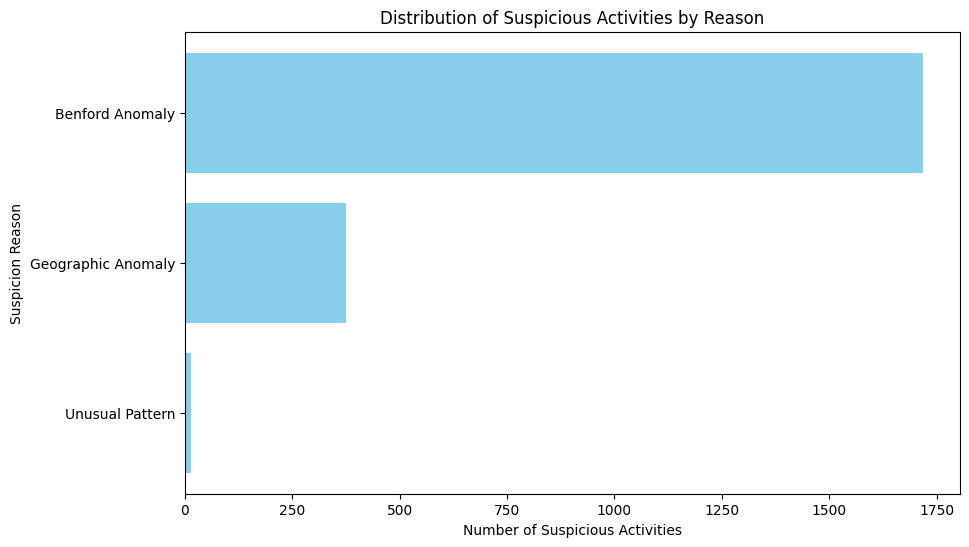

In [ ]:
import matplotlib.pyplot as plt

# Group by suspicion reason and count occurrences
suspicion_reason_counts = suspicious_activities_combined.groupBy('suspicion_reason').count().orderBy('count', ascending=False).toPandas()

# Plot the bar chart
plt.figure(figsize=(10,6))
plt.barh(suspicion_reason_counts['suspicion_reason'], suspicion_reason_counts['count'], color='skyblue')
plt.xlabel('Number of Suspicious Activities')
plt.ylabel('Suspicion Reason')
plt.title('Distribution of Suspicious Activities by Reason')
plt.gca().invert_yaxis()
plt.show()


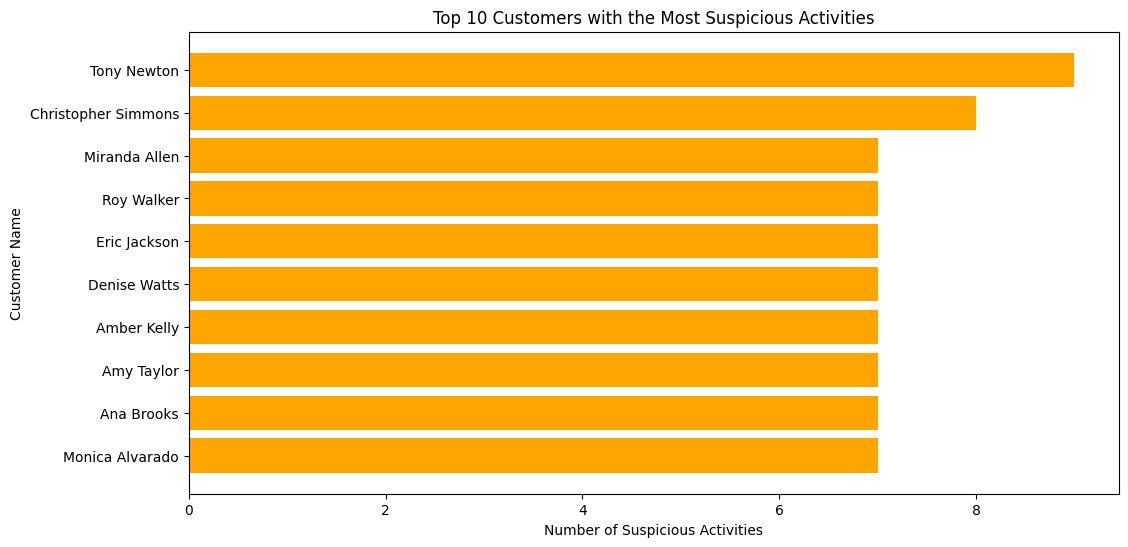

In [ ]:
# Count suspicious activities per customer
top_customers = suspicious_activities_combined.groupBy('customer_id').count().orderBy('count', ascending=False).limit(10).toPandas()

# Merge with customer details for better visualization
top_customers = top_customers.merge(customers_df.toPandas(), on='customer_id')

# Plot the bar chart
plt.figure(figsize=(12,6))
plt.barh(top_customers['name'], top_customers['count'], color='orange')
plt.xlabel('Number of Suspicious Activities')
plt.ylabel('Customer Name')
plt.title('Top 10 Customers with the Most Suspicious Activities')
plt.gca().invert_yaxis()
plt.show()


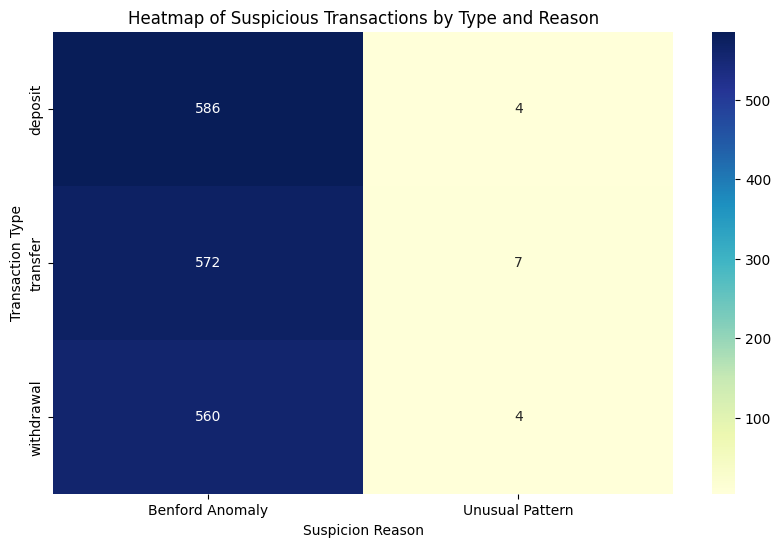

In [ ]:
import seaborn as sns
import pandas as pd

# Extract transaction type and suspicion reason
heatmap_data = transactions_df.join(suspicious_activities_combined, on='transaction_id', how='inner')\
    .groupBy('transaction_type', 'suspicion_reason').count().toPandas()

# Pivot for heatmap (using keyword arguments)
heatmap_pivot = heatmap_data.pivot(index="transaction_type", columns="suspicion_reason", values="count").fillna(0)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_pivot, annot=True, fmt="g", cmap="YlGnBu")
plt.title('Heatmap of Suspicious Transactions by Type and Reason')
plt.xlabel('Suspicion Reason')
plt.ylabel('Transaction Type')
plt.show()


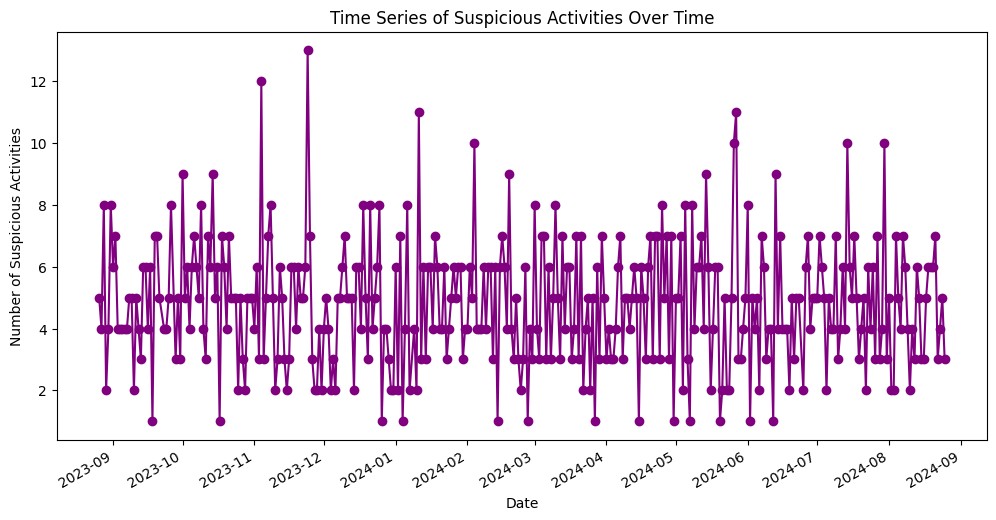

In [ ]:
from pyspark.sql.functions import to_date, col
import matplotlib.dates as mdates

# Convert transaction_date to date format and group by date
time_series_data = suspicious_activities_combined.join(transactions_df, on='transaction_id', how='inner')\
    .withColumn('date', to_date(col('transaction_date')))\
    .groupBy('date').count().orderBy('date').toPandas()

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(time_series_data['date'], time_series_data['count'], marker='o', color='purple')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Number of Suspicious Activities')
plt.title('Time Series of Suspicious Activities Over Time')
plt.show()


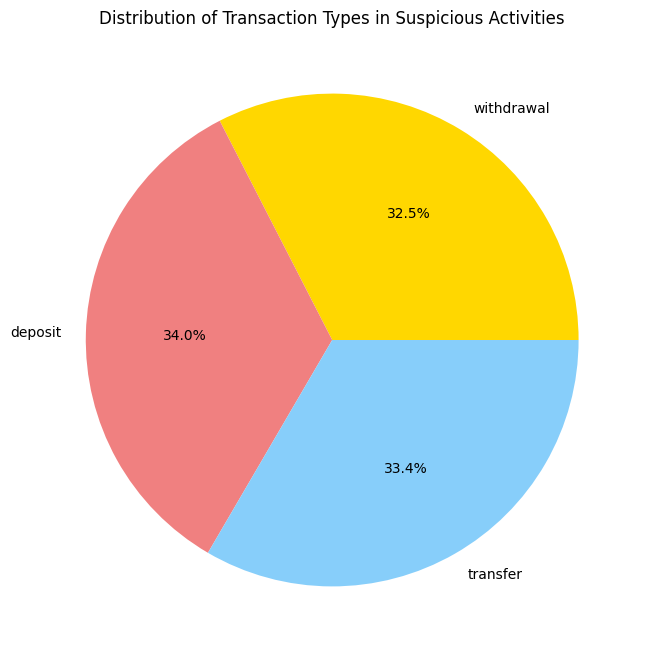

In [ ]:
# Count occurrences of each transaction type in suspicious activities
transaction_type_distribution = suspicious_activities_combined.join(transactions_df, on='transaction_id', how='inner')\
    .groupBy('transaction_type').count().toPandas()

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(transaction_type_distribution['count'], labels=transaction_type_distribution['transaction_type'], autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue'])
plt.title('Distribution of Transaction Types in Suspicious Activities')
plt.show()
